Implementation of the base model (June 12)
---

In [21]:
from gurobipy import Model, GRB, quicksum
import numpy as np
import pandas as pd
import openpyxl

## 0 Instances

### Read the file from local directory

Arthur's:

'/Users/arthurdebelle/Desktop/TUM/SoSe 2024/Ad.S - OM/Project/CODING/Airports data/Brussels (EBBR)/Brussels_Clean.xlsm'

Ting-Ying's:

'/Users/chentingying/Documents/tum/Ad_Se_Operation_Management/Airports_data/Brussels_Clean.xlsm'

In [44]:
''' For now: change local_path to represent acctual directory'''

local_path = '/Users/chentingying/Documents/tum/Ad_Se_Operation_Management/Airports_data/Brussels_Clean.xlsm'

# Reading the number of flights Brussels airport
flightCount = len(pd.read_excel(local_path, sheet_name='EBBR - Flights', usecols='A:T', skiprows=2))
flightsBrussels = pd.read_excel(local_path, usecols='A:T', skiprows=1, nrows=flightCount)
print("flightCount: ", flightCount)

# Reading the number of Gates from Brussels airport
gateCount = len(pd.read_excel(local_path, sheet_name='EBBR - Gates', usecols='A:D', skiprows=1))
gatesBrussels = pd.read_excel(local_path, sheet_name='EBBR - Gates', usecols='A:D', skiprows=0, nrows=gateCount)
print("gateCount: ", gateCount)
'''add a dummy gate?'''

flightCount:  174
gateCount:  149


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


### Parameters

In [12]:
### Model 4 (CPP) ###
'''
# n = number of flights, m = number of gates
# T = matrix of time differences, P = preferences matrix
# alpha1, alpha2, alpha3 = weight factors, t_max = maximum buffer time
# U = successor function, M = valid gate assignments for each flight
# '''

# Inputs
n = flightCount # Number of flights
m = gateCount + 1 # Number of real gates + 1 dummy gate (Should I +1 or not?)

# Flight columns
Flight_No = flightsBrussels['Flight']   # Aircrafts' flight number @ arrival
ETA = flightsBrussels['ETA']
ETD = flightsBrussels['ETD']
E_Parking = flightsBrussels['Planned Duration']
RTA = flightsBrussels['RTA']
RTD = flightsBrussels['RTD']
R_Parking = flightsBrussels['Real Duration']
Tot_Delay = flightsBrussels['Total Delay']
AC_size = flightsBrussels['AC size (m)']

# Tests
FN2 = Flight_No.tolist()

# Gates columns
Gate_Name = gatesBrussels['Name']
Max_Wingspan = gatesBrussels['Max length (m)']   # Max wingspan allowed on that gate

'''No idea what this is'''
# matrix of time differences of arrivals
# buffer time
# T = [
#     [0, 10, 15, 20],  # Flight 1 can sequentially follow Flights 2, 3, 4
#     [10, 0, 15, 25],  # Flight 2 can sequentially follow Flights 1, 3, 4
#     [15, 15, 0, 30],  # Flight 3 can sequentially follow Flights 1, 2, 4
#     [20, 25, 30, 0]   # Flight 4 can sequentially follow Flights 1, 2, 3
# ]

# Building U -> U[i] = successor of i (=0 if no successor)
U = []
for i in range(n):
    U.extend([3*i+1, 3*i+2, 0])     # U = [1,2,0, 4,5,0, ...]
# print(f"U = {U}")

'''
i = 0,1,2 = "Landing", "Parking" and "Departure" index for the 1st flight of the day; i = 3,4,5 = ...
U[1] = 2    -> Parking of 1st flight has Departure of 1st flight as successor
U[5] = 0    -> Departure of 2nd flight has no successor
i%3 = 0     -> landing of a flight x,     with x = (i-i%3)/3 
i%3 = 1     -> parking of a flight x,     with x = (i-i%3)/3 
i%3 = 2     -> departure of a flight x,   with x = (i-i%3)/3 
'''

# Building M
M = Gate_Name.tolist()
'''
For now: M = [0,1,2,...] = allowed gates for ALL flights
Later: make it [[0, 3, 50, ...], ...] when we have preferences for each flights individually
'''

alpha1 = 1   # Preference scaling factor
alpha2 = 20  # Reward for avoiding tows
alpha3 = 100  # Penalty scaling factor for buffer time deficits

t_max = 30

shadow_constraints = [
    (0, 1),  # Flights 1 and 2 cannot be in the same clique.
    (2, 3),  # Flights 3 and 4 cannot be in the same clique.
    (0, 5),  # Flight 1 and Gate 2 cannot be in the same clique. (assuming 5 is the index for Gate 2)
    (4, 5)   # Gate 1 and Gate 2 cannot be in the same clique. (assuming 4 is the index for Gate 1 and 5 is the index for Gate 2)
]

### Example Inputs

In [90]:
# Example Inputs1

flights = ['Flight 1', 'Flight 2', 'Flight 3', 'Flight 4', 'Flight 5', 'Flight 6']
n = len(flights)  # Number of flights

gates = ['Gate 1', 'Gate 2', 'Dummy Gate']
m = len(gates)  # Number of (real gates + dummy gate)

T = [
    [0, 10, -5, 20, 25, 30],  # Flight 1 can sequentially follow Flights 2, 4, 5, 6
    [10, 0, 15, 25, -10, 30],  # Flight 2 can sequentially follow Flights 1, 3, 4, 6
    [-5, 15, 0, 30, 35, 40],  # Flight 3 can sequentially follow Flights 2, 4, 5, 6
    [20, 25, 30, 0, 15, 20],  # Flight 4 can sequentially follow Flights 1, 2, 3, 5, 6
    [25, -10, 35, 15, 0, 30],  # Flight 5 can sequentially follow Flights 1, 2, 3, 4, 6
    [30, 30, 40, 20, 30, 0]   # Flight 6 can sequentially follow Flights 1, 2, 3, 4, 5
]
P = [
    [50, 30, 20],  # Preferences of Flight 1 for Gates 1, 2, and 3
    [40, 60, 20],  # Preferences of Flight 2 for Gates 1, 2, and 3
    [30, 70, 50],  # Preferences of Flight 3 for Gates 1, 2, and 3
    [20, 80, 60],  # Preferences of Flight 4 for Gates 1, 2, and 3
    [60, 40, 30],  # Preferences of Flight 5 for Gates 1, 2, and 3
    [70, 50, 40]   # Preferences of Flight 6 for Gates 1, 2, and 3
]
U = [0, 1, 2, 3, 4, 5]
M = [
    [0, 1, 2],  # Flight 1 can go to Gates 1, 2, and 3
    [0, 1, 2],  # Flight 2 can go to Gates 1, 2, and 3
    [0, 1, 2],  # Flight 3 can go to Gates 1, 2, and 3
    [0, 1, 2],  # Flight 4 can go to Gates 1, 2, and 3
    [0, 1, 2],  # Flight 5 can go to Gates 1, 2, and 3
    [0, 1, 2]   # Flight 6 can go to Gates 1, 2, and 3
]

alpha1 = 1   # Preference scaling factor
alpha2 = 20  # Reward for avoiding tows
alpha3 = 100  # Penalty scaling factor for buffer time deficits

t_max = 30

# Example shadow constraints based on hypothetical rules
# cannot be in the same clique
shadow_constraints = [
    (0, 1),  # Flight 1 and Flight 2 cannot be in the same clique
    (2, 3),  # Flight 3 and Flight 4
    (1, 5),  # Flight 2 and Gate 2 (assuming 5 is the index for Gate 2)
    (6, 7),  # Gate 1 and Gate 2 (assuming 6 is the index for Gate 1 and 7 is the index for Gate 2)
    (4, 8),  # Flight 5 and Gate 3 (assuming 8 is the index for Gate 3)
    (7, 8)   # Gate 2 and Gate 3
]

# Additional consideration for Dummy Gate usage
# Ensuring that at most one flight uses the Dummy Gate might involve additional handling in the logic or model setup.



In [81]:
# Example Inputs2
# run either Inputs1 or Inputs2

flights = ['Flight 1', 'Flight 2', 'Flight 3', 'Flight 4', 'Flight 5', 'Flight 6', 'Flight 7', 'Flight 8']
# Number of flights
n = len(flights)  

gates = ['Gate 1', 'Gate 2', 'Gate 3', 'Dummy Gate']
# Number of real gates + 1 dummy gate
m = len(gates) 

# Time differences indicating when one flight can follow another
T = [
    [0, 15, -10, 25, 35, 40, 20, 30],   # Flight 1
    [15, 0, 20, -5, 10, 25, 30, 35],    # Flight 2
    [-10, 20, 0, 30, -5, 15, 25, 40],   # Flight 3
    [25, -5, 30, 0, 20, -10, 35, 45],   # Flight 4
    [35, 10, -5, 20, 0, 30, -10, 25],   # Flight 5
    [40, 25, 15, -10, 30, 0, 20, 35],   # Flight 6
    [20, 30, 25, 35, -10, 20, 0, 15],   # Flight 7
    [30, 35, 40, 45, 25, 35, 15, 0]     # Flight 8
]

# Preferences for each flight regarding each gate
P = [
    [60, 50, 40, 30],  # Flight 1
    [70, 60, 50, 20],  # Flight 2
    [30, 80, 60, 50],  # Flight 3
    [40, 30, 70, 60],  # Flight 4
    [50, 40, 30, 80],  # Flight 5
    [60, 50, 40, 30],  # Flight 6
    [70, 80, 60, 50],  # Flight 7
    [30, 40, 50, 60]   # Flight 8
]

# Successor function for each flight
U = [0, 1, 2, 3, 4, 5, 6, 7]

# Valid gate assignments for each flight
M = [
    [0, 1, 2],    # Flight 1 can go to Gate 1, 2, 3
    [0, 1, 2],    # Flight 2
    [0, 1, 2, 3], # Flight 3
    [1, 2, 3],    # Flight 4
    [0, 1, 3],    # Flight 5
    [1, 2, 3],    # Flight 6
    [0, 2, 3],    # Flight 7
    [1, 3]        # Flight 8
]

# Weight factors
alpha1 = 1   # Preference scaling factor
alpha2 = 20  # Reward for avoiding tows
alpha3 = 100  # Penalty scaling factor for buffer time deficits

# Maximum buffer time
t_max = 30

# Shadow constraints based on hypothetical rules
shadow_constraints = [
    (0, 1),  # Flight 1 and Flight 2 cannot be in the same clique
    (3, 4),  # Flight 4 and Flight 5
    (2, 6),  # Flight 3 and Flight 7
    (5, 7),  # Flight 6 and Flight 8
    (1, 2),  # Flight 2 and Flight 3
    (6, 7)   # Flight 7 and Flight 8
]


### Vertices and Weights

In [91]:
# Calculate and store vertices and weight into variables

def get_vertices(n, m):
    return n + m -1 # Excludes dummy gate

vertices = get_vertices(n, m)
print("Vertices: ", vertices)

def get_weight_matrix(n, m, T, P, U, M, alpha1, alpha2, alpha3, t_max):
    a = get_vertices(n, m)
    
    # Initialize the edge weights matrix
    weights = [[0] * a for _ in range(a)]
    '''weights = [0]*len(a)''' #But "a" in an int, and object of type 'int' has no len()
    large_negative = -1e6  # A large negative number to represent -inf

    # Populate the weights matrix based on given rules (6)
    for i in range(n):
        for j in range(n):
            if i != j:
                if T[i][j] < 0: # Activities overlap in time
                    weights[i][j] = large_negative
                    '''What will be a recommanded way to handle -inf? 
                    -inf is not allowed in weight matrix
                    Because I can't multiply and sum them in the objective function'''

                elif U[i] == j or U[j] == i: # Saving a tow
                    weights[i][j] = alpha2  
                else:
                    weights[i][j] = -alpha3 * max(t_max - T[i][j], 0)  # Buffer time difference
    
    # Weights for flight to gate assignments (7)
    for i in range(n):
        for j in range(n, a):
            if j - n in M[i]:
                weights[i][j] = alpha1 * P[i][j - n]
            else:
                weights[i][j] = large_negative
    
    # Gates cannot be in the same clique (8)
    for i in range(n, a):
        for j in range(n, a):
            weights[i][j] = large_negative

    return weights


weights = get_weight_matrix(n, m, T, P, U, M, alpha1, alpha2, alpha3, t_max)
print("Weights matrix: ", weights)

Vertices:  8
Weights matrix:  [[0, -2000, -1000000.0, -1000, -500, 0, 50, 30], [-2000, 0, -1500, -500, -1000000.0, 0, 40, 60], [-1000000.0, -1500, 0, 0, 0, 0, 30, 70], [-1000, -500, 0, 0, -1500, -1000, 20, 80], [-500, -1000000.0, 0, -1500, 0, 0, 60, 40], [0, 0, 0, -1000, 0, 0, 70, 50], [0, 0, 0, 0, 0, 0, -1000000.0, -1000000.0], [0, 0, 0, 0, 0, 0, -1000000.0, -1000000.0]]


2 FGS as Clique Partitioning Problem (CPP)
---

Assumptions
1. Flights are represented as nodes in a graph.
2. Conflicts between flights are represented as edges.
3. Each clique represents a set of flights that can be assigned to the same gate without conflict.

In [92]:
# Callback function to add lazy constraints
'''The mycallback function you're referring to is used within the context of a Gurobi optimization model to implement lazy constraints.
Lazy constraints are a method used in integer programming where certain constraints are added to the model as they are needed during the branch-and-cut process rather than being added at the very beginning.
This can help to reduce the size of the model and speed up the initial solution process, adding constraints only when necessary to cut off infeasible solutions found along the way.
'''
def mycallback(model, where):
    if where == GRB.Callback.MIPSOL: # checks if it is being called at the MIPSOL (MIP solution) stage
        for (i, j) in model._shadow_constraints:
            if (i, j) in model._x and model.cbGetSolution(model._x[i, j]) > 0.5: # checks if the value of the decision variable model._x[i, j] in the current solution is greater than 0.5.
                '''How to design the constant above? '''
                model.cbLazy(model._x[i, j] == 0)

In [93]:
def build_cpp_model(vertices, weights):
    model = Model("GateAssignmentCPP")
    model.setParam(GRB.Param.LazyConstraints, 1)  # Enable lazy constraints

    a = vertices

    # Decision variables: x[i, j] = 1 if i and j are in the same clique, 0 otherwise
    '''Your variable space is twice as large as it needs to be. Instead, only define variables x[i,j] for i < j.'''
    '''How about the current one?'''
    x = {}
    for i in range(a):
        for j in range(i + 1, a):
            x[i, j] = model.addVar(vtype=GRB.BINARY, name=f"x[{i},{j}]")
    
    # Objective: Maximize the sum of the weights for edges within the same clique
    model.setObjective(quicksum(weights[i][j] * x[i, j] for i in range(a) for j in range(i + 1, a)), GRB.MAXIMIZE)

    # Add transitivity constraints for forming valid cliques (4)
    for i in range(a):
        for j in range(a):
            for k in range(a):
                #''' 1 <= i and k <= a are not needed. Your iterator for i starts at 0 and k <= a holds by definition.'''
                if i < j and j < k:
                    model.addConstr(x[i, j] + x[j, k] - x[i, k] <= 1)
                    model.addConstr(x[i, j] - x[j, k] + x[i, k] <= 1)
                    model.addConstr(-x[i, j] + x[j, k] + x[i, k] <= 1)

    # Store variables and constraints for the callback
    model._x = x
    model._shadow_constraints = shadow_constraints

    # Optimize with the callback function to add lazy constraints
    model.optimize(mycallback)
    
    return model, x

In [94]:
# Build the model
model, x = build_cpp_model(vertices, weights)
    
# Print solution
if model.status == GRB.Status.OPTIMAL:
    print()
    print(f"Optimal solution found with total score: {model.objVal}")
    solution = model.getAttr('x', x)
    cliques = {}
    for (i, j), value in solution.items():
        if value > 0.5:
            if i in cliques:
                cliques[i].append(j)
            else:
                cliques[i] = [j]
            if j in cliques:
                cliques[j].append(i)
            else:
                cliques[j] = [i]

    # Print cliques
    for i in range(n):
        if i in cliques:
            clique = [i] + cliques[i]
            flights = [f"Flight {x+1}" for x in clique if x < n]
            gates = [f"Gate {x-n+1}" for x in clique if x >= n]
            print(f"Flight {i+1} is in a clique with {', '.join(flights + gates)}")
        else:
            print(f"Flight {i+1} did not obtain any particular gate assignment")

    for i in range(n, n + m):
        if i in cliques:
            clique = [i] + cliques[i]
            gates = [f"Gate {x-n+1}" for x in clique if x >= n]
            flights = [f"Flight {x+1}" for x in clique if x < n]
            print(f"Gate {i-n+1} is in a clique with {', '.join(gates + flights)}")
else:
    print("No optimal solution found.")


Set parameter LazyConstraints to value 1
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 168 rows, 28 columns and 504 nonzeros
Model fingerprint: 0xd980015a
Variable types: 0 continuous, 28 integer (28 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 110.0000000
Presolve time: 0.00s
Presolved: 168 rows, 28 columns, 504 nonzeros
Variable types: 0 continuous, 28 integer (28 binary)
Found heuristic solution: objective 280.0000000
Root relaxation presolved: 70 rows, 18 columns, 179 nonzeros


Root relaxation: objective 3.000000e+02, 11 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf

## 3 Ejection Chain Algorithm

### Algorithm 2: Initial Solution Generation

In [57]:
def initialize_solution(vertices, U):
    """
    Initialize the solution where no two vertices are in relation, marking tabu for vertices with dependencies.
    """
    
    # 0. 
    solution = [None] * vertices  # None implies no cluster assignment
    tabu = set()

    # 1. Mark vertices with dependencies as tabu
    for i in range(n):
        if U[i] != 0: 
            tabu.add(i)
            if U[i] != i:  # Check to ensure not marking the same vertex if it's its own successor
                tabu.add(U[i])

    return solution, tabu

# 2.
def find_best_reassignment(vertices, weights, M, U, tabu):
    """
    Find the best vertex and cluster pair that maximizes the heuristic and is not tabu.
    """

    best_i = None # best vertex (flight activity)
    best_D = None # best new cluster
    best_value = float('-inf')

    # Iterate over all non-tabu vertices
    for i in range(vertices):
        if i in tabu:
            continue

        for D in M[i]:
            # Calculate heuristic h(i, C(i), D)
            h_value = calculate_heuristic(i, D, U, weights, vertices)

            # Check if this is the best found so far
            if h_value > best_value:
                best_value = h_value
                best_i = i
                best_D = D

    return best_i, best_D, best_value

def calculate_heuristic(i, D, U, weights, vertices):
    """
    Calculate the heuristic value for moving vertex i to cluster D.
    """
    heuristic_value = 0
    # Ensure i is within the valid index range for weights and U
    if i < len(weights) and i < len(U):
        for j in range(vertices):
            if j != i and j < len(weights[i]) and j < len(U):
                # Only add to heuristic_value if D matches U[j], ensuring j indices are safe
                if D == U[j]:
                    heuristic_value += weights[i][j]

    return heuristic_value
# GPT helps me but what is this?

def algorithm_2(vertices, weights, U, M):
    """
    Algorithm 2: Initial solution generation.
    """
    solution, tabu = initialize_solution(vertices, U)
    
    # Iteratively find and perform the best reassignment that is not tabu
    while True:
        i_star, D_star, improvement = find_best_reassignment(vertices, weights, M, U, tabu)
        
        if improvement <= 0:
            break  # Stop if no improvement is possible

        # 3. Assign and update tabu status
        solution[i_star] = D_star
        tabu.add(i_star)  # Mark this vertex as tabu after moving

    return solution



# Example usage:
initial_solution = algorithm_2(vertices, weights, U, M)
print("Initial solution:", initial_solution)

IndexError: list index out of range

### Algorithm 1: Core Ejection Chain Algorithm

In [ ]:
def algorithm_1(initial_solution):
    """
    Execute the first algorithm of the ejection chain process.
    
    Parameters:
        vertices (int): Number of vertices in the graph.
        weights (list of lists): Adjacency matrix representing the weights between vertices.
        initial_solution (list): The initial solution where no two vertices are related.
    
    Returns:
        list: The improved or best found solution.
    """

    vertices = get_vertices(n, m)
    weights = get_weight_matrix(n, m, T, P, U, M, alpha1, alpha2, alpha3, t_max)

    # 0. Initialization
    solution = initial_solution[:]
    tabu_list = set()
    improved = True

    while improved:
        improved = False
        best_move = None
        best_delta = float('-inf')
        
        # 1. Finding a sequence of n moves
        for i in range(vertices):
            if i in tabu_list:
                continue
            current_cluster = solution[i]
            
            for j in range(vertices):
                if j != i and j not in tabu_list:
                    potential_cluster = solution[j]
                    # Calculate the delta of moving vertex i to cluster of vertex j
                    if current_cluster is not None:
                        delta = -sum(weights[i][k] for k in range(vertices) if solution[k] == current_cluster and k != i)
                    else:
                        delta = 0
                    
                    delta += sum(weights[i][k] for k in range(vertices) if solution[k] == potential_cluster and k != i)
                    
                    if delta > best_delta:
                        best_delta = delta
                        best_move = (i, j)

        # 2. Apply the best move if it improves the solution
        if best_move and best_delta > 0:
            i, j = best_move
            # Update the solution
            solution[i] = solution[j]
            tabu_list.add(i)
            improved = True

        # Clear the tabu list if no improvement
        if not improved:
            tabu_list.clear()

    return solution

# Example usage:
result = algorithm_1(vertices, weights, initial_solution)
print("Final solution:", result)


Final solution: [None, None, None, None, None, None, None, None, None, None, None]


### Algorithm 3: Putting It All Together

In [ ]:
def algorithm_3(vertices, weights, U, M, max_restarts=7):
    """
    Iteratively improve the solution using Algorithm 2 and 1.
    
    Parameters:
        vertices (int): Total number of vertices including flights and gates.
        weights (list of lists): Adjacency matrix representing the weights between vertices.
        U (list): Successor information for each vertex.
        M (list of lists): List of allowable gates for each vertex.
        max_restarts (int): Maximum number of restarts allowed to avoid infinite loops.
    
    Returns:
        list: The best solution found after iterations.
    """
    best_solution = algorithm_2(vertices, weights, U, M)
    best_score = calculate_score(best_solution, weights)
    
    for _ in range(max_restarts):
        new_solution = algorithm_1(best_solution, weights, U, M)
        new_score = calculate_score(new_solution, weights)
        
        if new_score > best_score:
            best_solution = new_solution
            best_score = new_score
        else:
            break  # Stop if no improvement
    
    return best_solution

def calculate_score(solution, weights):
    """
    Calculate the total score of the solution based on the weights matrix.
    """
    score = 0
    for i in range(len(solution)):
        if solution[i] is not None:
            score += weights[i][solution[i]]
    return score

def algorithm_1(solution, weights, U, M):
    """
    Refine the given solution by attempting to reallocate vertices to improve the overall score.
    This is a placeholder for the detailed steps of Algorithm 1.
    """
    # Implement the details of Algorithm 1 as specified, considering tabu list, weights, etc.
    # For simplicity here, just return the input solution.
    return solution

# Example usage:
vertices = get_vertices(n, m)
weights = get_weight_matrix(n, m, T, P, U, M, alpha1, alpha2, alpha3, t_max)

optimal_solution = algorithm_3(vertices, weights, U, M)
print("Optimal solution:", optimal_solution)


IndexError: list index out of range

1 Flight-Gate Scheduling (FGS) Problem
---

not the point, can come back later

In [ ]:
# Wait for update 

# Callback function to add lazy constraints
def mycallback(model, where):
    if where == GRB.Callback.MIPSOL:
        for (i, j) in model._shadow_constraints:
            if (i, j) in model._x and model.cbGetSolution(model._x[i, j]) > 0.5:
                model.cbLazy(model._x[i, j] == 0)

def build_FGS_model(n, m, P, U, T, M, shadow_restrictions, alpha1, alpha2, alpha3, t_max):
    model = Model("FlightGateScheduling")
    model.setParam(GRB.Param.LazyConstraints, 1)  # Enable lazy constraints

    # Decision variables for each activity being assigned to each gate
    x = model.addVars(n, m + 1, vtype=GRB.BINARY, name="x") # Number of real gates is num_gates; the last index is assumed to be the dummy gate

    # Constraints
    # Assign each activity to exactly one of its allowable gates
    for i in range(n):
        model.addConstr(quicksum(x[i, j] for j in range(m+1) if j in M[i]) == 1, name=f"Assign_{i}") 
        #'''can include dummy gate it in this quicksum (might leader to a tighter LP relaxation)'''

    # Non-overlapping constraint (1)
    for i in range(n):
        for j in range(n):
            if T[i][j] < 0:
                for k in range(m):
                    model.addConstr(x[i, k] + x[j, k] <= 1, name=f"Overlap_{i}_{j}_{k}")

    # Shadow restrictions (2)
    for (i, k, j, l) in shadow_restrictions:
        model.addConstr(x[i, k] + x[j, l] <= 1, name=f"Shadow_{i}_{j}")

    # Objective components (3)
    
    # Append significantly negative scores for the dummy gate
    P_star = [prefs + [-1000] for prefs in P]  # Add a very undesirable score for the dummy gate

    # z1: Minimize the negative sum of adjusted preferences
    z1 = - quicksum(P_star[i][j] * x[i, j] for i in range(n) for j in range(m + 1)) 
    #''' - quicksum(P_star[i][j] * x[i, j] for (i,j) in x). negative is important!'''
    
   
    # Define a new decision variable for tows between activities and their successors
    '''Good practice: first define ALL variables, then define ALL constraints, and ultimately define the objective function
    '''
    tows = model.addVars(n, m+1, vtype=GRB.BINARY, name="tows")
    #'''Towing to the dummy gate also needs to be possible (-> tighter lower bounds)'''

    # Calculate tows:
    for i in range(n):
        '''Each activity must have a successor, i.e. U[i] \in N for all i
        In the trivial case that would be the activity itself (->U[i] = i)'''
        for k in range(m+1):
            if U[i] != i:  # Check for a valid successor

                # If activity i is assigned to gate k and its successor U[i] to a different gate
                model.addConstr(tows[i, k] >= x[i, k] - x[U[i], k], name=f"TowIfDifferent_{i}_{k}")

                # model.addConstr(tows[i, k] >= x[i, k] - x[U[i], k], name=f"TowIfDifferent1_{i}_{k}")
                # model.addConstr(tows[i, k] >= x[U[i], k] - x[i, k], name=f"TowIfDifferent2_{i}_{k}")
                '''If I understand it correctly, it should be that tows[i,k] = 1 <=> flight associated with activity i
                needs to be towed away from gate k after activity i is done.
                First constraint: "if activity i is assigned to gate k, but its successor is not, we need to tow the plane 
                away from k after finishing i"
                second constraint: "if activity i is NOT assigned to gate k, but its success is, we need to tow the plane
                towards k after finishing i"
                The latter constraint set would then lead to every tow being counted twice if I'm not mistaken
                '''

    # Redefine z2 using the new tow variables
    z2 = quicksum(tows[i, k] for i in range(n) for k in range(m))

    # z3: Buffer time deficit
    # z3 = quicksum(max(t_max - T[i][j], 0) * x[i, k] * x[j, k] for i in range(n) for j in range(i +1, n) for k in range(m))
    '''This is a quadratic constraint. It can be linearized by introducing variables buffer[i,j] for activities i and j,
    bounding them from above by x[i,k]*(max(t_max - T_[i][j],0)) and x[j,k]*(max(t_max - T_[i][j],0)).
    '''

    buffer = model.addVars(n, n, vtype=GRB.BINARY, name="buffer")
    # TODO: Implement new buffer time constraint here


    
    
    # Combined objective
    model.setObjective(alpha1 * z1 + alpha2 * z2 + alpha3 * z3, GRB.MINIMIZE)
    model.optimize()

    return model, x, tows

<>:52: SyntaxWarning: invalid escape sequence '\i'
<>:52: SyntaxWarning: invalid escape sequence '\i'
/var/folders/mw/4d26229d25302_j476mymn740000gn/T/ipykernel_12084/1195286764.py:52: SyntaxWarning: invalid escape sequence '\i'
  '''Each activity must have a successor, i.e. U[i] \in N for all i


In [ ]:
# Build the model
model, x = build_FGS_model(n, m, P, U, T, M, shadow_restrictions, alpha1, alpha2, alpha3, t_max)  # Receive model and decision variables

# Print the results
if model.status == GRB.OPTIMAL:
    assignments = model.getAttr('X', x)
    for i in range(n):
        for j in range(m):
            if assignments[i, j] > 0.5:
                print(f"Activity {i} assigned to Gate {j}")


Restricted license - for non-production use only - expires 2025-11-24
Set parameter LazyConstraints to value 1


/var/folders/mw/4d26229d25302_j476mymn740000gn/T/ipykernel_12084/1195286764.py:52: SyntaxWarning: invalid escape sequence '\i'
  '''Each activity must have a successor, i.e. U[i] \in N for all i


NameError: name 'z3' is not defined

## Draw a graph

Doesn't help

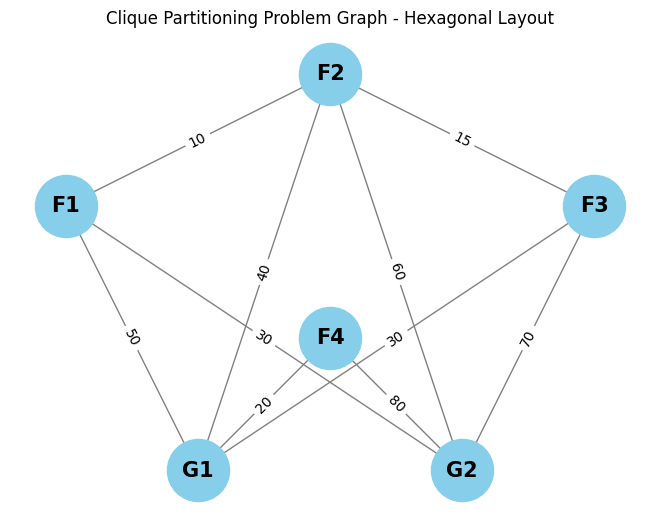

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_cpp_graph(flights, gates, connections):
    """
    Draws a CPP graph with given flight and gate nodes and their connections in a hexagonal-like layout.
    
    Parameters:
    - flights (dict): Dictionary where keys are flight labels and values are dicts of gate connections with weights.
    - gates (list): List of gate labels.
    - connections (dict): Optional additional edges between flights with weights.
    """
    # Create a graph
    G = nx.Graph()

    # Add nodes for flights and gates
    G.add_nodes_from(flights.keys(), style='filled', fillcolor='red', shape='circle')
    G.add_nodes_from(gates, style='filled', fillcolor='blue', shape='square')

    # Add edges between flights and gates with preferences
    for flight, prefs in flights.items():
        for gate, weight in prefs.items():
            G.add_edge(flight, gate, weight=weight)

    # Add optional additional connections between flights
    for (f1, f2), weight in connections.items():
        G.add_edge(f1, f2, weight=weight)

    # Manually define positions for a hexagonal-like layout
    pos = {
        'F1': (-1, 1), 'F2': (0, 2), 'F3': (1, 1),  # Top vertex, and middle row vertices
        'F4': (0, 0),  # Bottom vertex of the upper hexagon (if we imagine a hexagon)
        'G1': (-0.5, -1), 'G2': (0.5, -1)  # Bottom vertices (gates)
    }

    # Draw the network
    nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=2000, font_size=15, font_weight='bold')

    # Draw edge labels
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title("Clique Partitioning Problem Graph - Hexagonal Layout")
    plt.axis('off')  # Hide the axes
    plt.show()

# Example usage
flights = {
    'F1': {'G1': 50, 'G2': 30},
    'F2': {'G1': 40, 'G2': 60},
    'F3': {'G1': 30, 'G2': 70},
    'F4': {'G1': 20, 'G2': 80}
}
gates = ['G1', 'G2']
additional_connections = {('F1', 'F2'): 10, ('F2', 'F3'): 15}

draw_cpp_graph(flights, gates, additional_connections)
